In [84]:
# sklearn dataset : https://scikit-learn.org/stable/datasets/index.html

from sklearn.datasets import load_iris

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, fbeta_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import silhouette_score, silhouette_samples


In [108]:
# ---------- X : dataframe 피쳐 , clables:centroid_pred
def myscore(X, clabels, model=None):
    score_df = pd.DataFrame()
    scoef = silhouette_samples(X, clabels)
    score_df["scoef"] = scoef
    score_df["cluster_pred"] = clabels

    print("전체 평균  실루엣 계수:", np.mean(scoef))
    print(score_df.groupby("cluster_pred")["scoef"].mean())
    
    if model != None:
        #inertia_ : Sum of squared distances of samples to their closest cluster center.
        #중앙점으로부터 각 점들의 거리^2 합
        #작을수록 중앙점으로 몰려있다 = 응집도가 높다
        print("응집도 : ", model.inertia_) #응집도

In [103]:
dataset = load_iris()
df = pd.DataFrame(data=dataset.data,
                  #columns=dataset.feature_names
                  columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
                  )
# df["target"] = dataset.target

#### KMeans.predict : 중심점(centroid) 선정

In [104]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=11)
model.fit(df[['sepal_length', 'sepal_width']])
cluster_pred = model.predict(df[['sepal_length', 'sepal_width']])

df["cluster_pred"] = cluster_pred
df["cluster_labels"] = model.labels_
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,cluster_pred,cluster_labels
145,6.7,3.0,5.2,2.3,2,2
146,6.3,2.5,5.0,1.9,0,0
147,6.5,3.0,5.2,2.0,2,2
148,6.2,3.4,5.4,2.3,2,2
149,5.9,3.0,5.1,1.8,0,0


#### 시각화 : 중심점,데이터

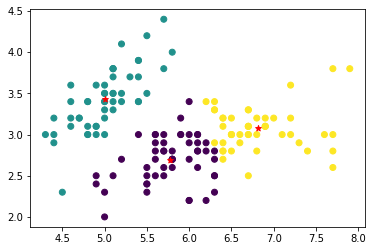

In [88]:
center_df = pd.DataFrame(model.cluster_centers_,columns=['sepal_length', 'sepal_width'] )
cx = center_df["sepal_length"]
cy = center_df["sepal_width"]

color = ["b","y","g"]
plt.scatter(df["sepal_length"], df["sepal_width"], c=df["cluster_pred"])
plt.scatter(cx, cy, c="r", marker="*")
# plt.legend()
plt.show()


#### 검증 : 군집 실루엣 계수

In [109]:
myscore(df[['sepal_length', 'sepal_width']], df["cluster_pred"], model)


전체 평균  실루엣 계수: 0.4450525692083638
cluster_pred
0    0.404766
1    0.490080
2    0.442581
Name: scoef, dtype: float64
응집도 :  37.0507021276596


## 주요 피쳐로 군집(clustering)

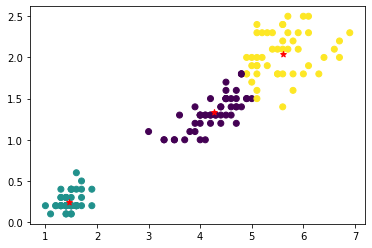

In [90]:
dataset = load_iris()
df = pd.DataFrame(data=dataset.data,
                  columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
                  )

model = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=11)
model.fit(df[['petal_length', 'petal_width']])
cluster_pred = model.predict(df[['petal_length', 'petal_width']])

df["cluster_pred"] = cluster_pred
df["cluster_labels"] = model.labels_

center_df = pd.DataFrame(model.cluster_centers_,columns=['petal_length', 'petal_width'] )
cx = center_df["petal_length"]
cy = center_df["petal_width"]

plt.scatter(df["petal_length"], df["petal_width"], c=df["cluster_pred"])
plt.scatter(cx, cy, c="r", marker="*")
plt.show()

In [110]:
myscore(df[['petal_length', 'petal_width']], df["cluster_pred"], model)

전체 평균  실루엣 계수: 0.5085037699826875
cluster_pred
0    0.354019
1    0.922468
2    0.242323
Name: scoef, dtype: float64
응집도 :  37.0507021276596


## 정규화 한 이후의 실루엣 계수

In [91]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
df_scaler = pd.DataFrame(scaler_data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df_scaler.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [111]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=11)
model.fit(df_scaler[['petal_length', 'petal_width']])
cluster_pred = model.predict(df_scaler[['petal_length', 'petal_width']])
df_scaler["cluster_pred"] = cluster_pred


myscore(df_scaler[['petal_length', 'petal_width']], df_scaler["cluster_pred"], model)

전체 평균  실루엣 계수: 0.6741313114151009
cluster_pred
0    0.510323
1    0.904516
2    0.603815
Name: scoef, dtype: float64
응집도 :  18.026962612544075


#### 최적의 군집 개수 찾기 / 검증(응집도)

전체 평균  실루엣 계수: 0.7433719503339133
cluster_pred
0    0.652617
1    0.924881
Name: scoef, dtype: float64
전체 평균  실루엣 계수: 0.6741313114151009
cluster_pred
0    0.510323
1    0.904516
2    0.603815
Name: scoef, dtype: float64
전체 평균  실루엣 계수: 0.5988016665822246
cluster_pred
0    0.388798
1    0.899435
2    0.504836
3    0.429358
Name: scoef, dtype: float64
전체 평균  실루엣 계수: 0.573563167783687
cluster_pred
0    0.475683
1    0.888731
2    0.368695
3    0.402670
4    0.411029
Name: scoef, dtype: float64


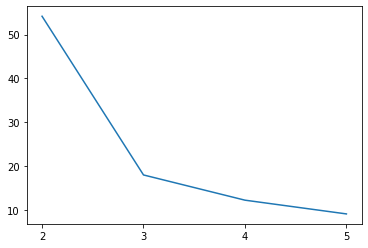

In [112]:
cluster_list = [2,3,4,5]
inertia_list = []
for c in cluster_list:
    model = KMeans(n_clusters=c, init='k-means++', max_iter=300, random_state=11)
    model.fit(df_scaler[['petal_length', 'petal_width']])
    cluster_pred = model.predict(df_scaler[['petal_length', 'petal_width']])
    df_scaler["cluster_pred"] = cluster_pred

    myscore(df_scaler[['petal_length', 'petal_width']], df_scaler["cluster_pred"])    

    #inertia_ : Sum of squared distances of samples to their closest cluster center.
    #중앙점으로부터 각 점들의 거리^2 합
    #작을수록 중앙점으로 몰려있다 = 응집도가 높다
    inertia_list.append(model.inertia_) #응집도

plt.plot(range(2,6), inertia_list)
plt.xlabel = "k-cluster"
plt.ylabel = "cluster inertia"
plt.xticks(range(2,6))
plt.show()

## 검증 : cross tabulation

In [77]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=11)
model.fit(df_scaler[['petal_length', 'petal_width']])
cluster_pred = model.predict(df_scaler[['petal_length', 'petal_width']])
df_scaler["cluster_pred"] = cluster_pred
df_scaler["target"] = dataset.target

ctab = pd.crosstab(df_scaler["target"],df_scaler["cluster_pred"])
print(ctab)


cluster_pred   0   1   2
target                  
0              0  50   0
1              2   0  48
2             46   0   4


### 주요피쳐 < 정규화 < 정규화+PCA ??
* 피쳐가 많아 모델이 복잡(과대적합)한 경우 or 학습이 불가한 경우 PCA가 효율적일 수 있다

In [113]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
pca = PCA(n_components=2)
pipeline = make_pipeline(scaler, pca)
pca_res = pipeline.fit_transform(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])

print(pca_res.shape)
print("주성분(PC) 2개가 전체 데이터를 얼마나 설명할수 있는가?\n", np.sum(pca.explained_variance_ratio_), pca.explained_variance_ratio_)


pca_df = pd.DataFrame(data=pca_res, columns=["pc1", "pc2"])



model = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=11)
model.fit(pca_df[["pc1", "pc2"]])
cluster_pred = model.predict(pca_df[["pc1", "pc2"]])
pca_df["cluster_pred"] = cluster_pred

myscore(pca_df[["pc1", "pc2"]], pca_df["cluster_pred"],model)



(150, 2)
주성분(PC) 2개가 전체 데이터를 얼마나 설명할수 있는가?
 0.9581320720000164 [0.72962445 0.22850762]
전체 평균  실루엣 계수: 0.5091683341538228
cluster_pred
0    0.441860
1    0.654065
2    0.430923
Name: scoef, dtype: float64
응집도 :  115.02075663594017
